In [1]:
import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm
from itertools import cycle
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

from prophet import Prophet

/tmp/ipykernel_80144/2586733365.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv("../rastro_1min.tar.gz", index_col=0)
df.head()

,overallusers,overallrbdw,overallrbdwmean,overallrbdwstd,overallratedw,overallratedwmean,overallratedwstd,overallmsgdw,overallretxdw,overallrbup,overallrbupmean,overallrbupstd,overallrateup,overallrateupmean,overallrateupstd,overallmsgup,overallretxup
overalltime,,,,,,,,,,,,,,,,,
2016-06-29 22:56:00,514,102539,19.737289,17.590780,27203112,3707.610350,4828.865308,3542,163,73861,3.443046,4.184972,8863072.0,434.507309,616.176033,10628.0,9784.0
2016-06-29 22:57:00,634,58511,16.470517,15.334160,7034656,2017.145780,2984.791050,3120,73,84479,3.385373,3.600891,8968600.0,373.483436,468.323626,14496.0,11233.0
2016-06-29 22:58:00,889,121123,16.866703,14.328054,22695704,2655.061443,3775.325510,5054,159,173947,6.576329,5.829330,14363056.0,544.011478,561.241565,19482.0,6716.0
2016-06-29 22:59:00,670,105240,18.245522,15.004146,19683368,2672.386192,3300.962021,3996,177,122518,6.762097,5.491740,9711008.0,540.194010,469.583361,14376.0,3372.0
2016-06-29 23:00:00,629,651738,27.337623,13.555662,169093944,5919.297844,4132.723859,14467,1120,124437,6.628143,6.706426,11546504.0,596.334224,698.955721,13902.0,4634.0


In [3]:
market = pd.date_range(start="2016/07/03 09:00:00", end="2016/08/01 00:00:00", freq="1w").tolist() + \
    pd.date_range(start="2016/07/03 16:00:00", end="2016/08/01 00:00:00", freq="1w").tolist()

In [4]:
def make_prediction(df, col):
    tmp = df[col].copy().reset_index().rename(columns={"overalltime":"ds", col:"y"})
    model = Prophet(yearly_seasonality=False, changepoint_range=.8, interval_width=.99)
    model.fit(tmp)
    forecast = model.predict(tmp)
    forecast = forecast[["ds", "yhat_lower", "yhat_upper"]].rename(
        columns={"ds": "overalltime", "yhat_lower":"lower", "yhat_upper":"upper"}
    ).set_index("overalltime")
    forecast[col] = df[col].values
    
    delta_upper = np.maximum(forecast[col] - forecast["upper"], 0)
    delta_lower = np.maximum(forecast["lower"] - forecast[col], 0)
    delta = np.where(delta_upper>delta_lower, delta_upper, delta_lower)
    
    forecast["anomaly"] = delta


    return (col,forecast)

In [5]:
def make_plot(df, col, **kwargs):
    fig, axs = plt.subplots(figsize=(30,3), nrows=2, sharex=True)
    axs[0].plot(df[col], **kwargs)
    axs[0].plot(df["upper"], c="k")
    axs[0].plot(df["lower"], c="k")
    axs[1].plot(df["anomaly"], **kwargs)

    for t in market:
        for ax in axs:
            ax.axvline(t, color="black", ls="-")

    axs[0].set_xlim(df.index.min(), df.index.max())

    axs[0].set_ylabel("Data")
    axs[1].set_ylabel("Anomaly Score")

    fig.suptitle(col)

    return fig
    

In [6]:
%%capture

results = Parallel(n_jobs=10)(delayed(make_prediction)(df,col) for col in df.columns)

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

Initial log joint probability = -354.279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0697
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -498.509
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -1624.35
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -54.6667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -33.2269
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -590.201
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -31.4216
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -135.29
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -69.7132
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        108846    0.00138321       655.283      0.3103      0.8246      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       76920.4    0.00583653       959.007           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       66322.8    0.00486699       508.643           1           1      124   
    Iter      log prob  

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     899        122553    0.00111315       258.503           1           1     1103   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       82680.7    0.00448809        750.24           1           1     1143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     992        119819     4.663e-05       72.5984           1           1     1131   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     805         58200   2.60533e-05       63.6085   1.863e-07       0.001     1183  LS failed, Hessian reset 
     999       88279.9     5.941e-05       103.662           1           1     1196   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       66359.8   9.58983e-05       68.8898           1           1     1349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1010       66359.8   4.33653e-06       60.9046      0.3423           1     1364   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     999       77009.2     0.0108402       1481.11           1           1     1301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        108905    0.00010067       214.834           1           1     1220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        143261   0.000152789       445.839      0.7211      0.7211     1171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        122556    0.00114201       1311.64           1           1     1215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       82686.6   0.000427922       800.042      0.2927      0.2927     1261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       88280.7   0.000196311        102.13           1           1     1310   
    Iter      log 

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     893       58200.6   5.43906e-05       141.748   5.974e-07       0.001     1321  LS failed, Hessian reset 
     899       58200.6   0.000106246       172.463           1           1     1329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       77010.5    0.00342841        208.62           1           1     1427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099        143262   0.000121491       971.637      0.6409      0.6409     1287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1066        122556   1.89421e-05       91.0328           1           1     1295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1140       82689.1    0.00020484       310.431   8.145e-07       0.001     1357  LS failed, Hessian reset 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1102       77010.6   3.83334e-05       228.003   2.294e-07       0.001     1475  LS failed, Hessian reset 
     929       58200.6   6.84138e-05       173.892   7.986e-07       0.001     1421  LS failed, Hessian reset 
    1199       88281.3   2.69039e-05       116.676           1           1     1432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     941       58200.6   1.81279e-06       49.1974      0.3534           1     1438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1199       82691.7    0.00056872       129.156      0.2324           1     1428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1179        143263   0.000127249       110.118      0.2442           1     1383   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1199       77011.3   0.000448265       147.661           1           1     1596   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299         82696   0.000492114        139.44           1           1     1543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1288       88281.6   7.46091e-06       57.4737      0.4761           1     1540   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1238       77012.3   2.02266e-05       119.976   7.398e-08       0.001     1695  LS failed, Hessian reset 
Initial log joint probability = -32.8969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -168.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       82699.1    0.00173257       308.284           1           1     1655   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.2434
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       77013.3    0.00179764       636.537           1           1     1768   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        116341   0.000412877       1370.41       1.348      0.1348      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.6386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       81595.6      0.013485       584.714           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1336       77013.7   4.69426e-05       70.5333   8.013e-07       0.001     1852  LS failed, Hessian reset 
    1499         82700    0.00544973       299.617      0.4909      0.4909     1777   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        137868   0.000974043        3514.5           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        116362    0.00480911       776.089           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        129012   4.41243e-05    

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -30.8085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699       82709.9   0.000138293        189.49      0.7365      0.7365     2054   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       81608.6    0.00112503       181.199      0.5151     0.05151      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -154.219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1499       77014.3   0.000394982       182.289      0.8532      0.8532     2103   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        129051    0.00197469       1599.46      0.4021      0.4021      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -260.551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        137917    0.00111977       2985.71           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        116386    0.00374381       948.388           1           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        118607     0.0151226       9292.08           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    2160       82717.3   1.77294e-05       151.908   1.166e-07       0.001     2824  LS failed, Hessian reset 
     699        118699   0.000403264       579.206      0.7731      0.7731      816   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1963       77016.7    2.1372e-05       139.983   2.388e-07       0.001     2801  LS failed, Hessian reset 
     780       81615.3    9.4364e-06       61.0613           1           1     1028   
     885        129067   5.66447e-05       90.0843           1           1     1025   
Optimization terminated normally: Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

  Convergence detected: relative gradient magnitude is below tolerance
     699       97817.1    0.00116333       324.416      0.1683           1      821   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1969       77016.7   2.24856e-

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

    2199       82717.4    0.00137767       159.002       2.472           1     2873   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099        116398   7.89174e-05       308.137      0.1754           1     1330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     745        118700   5.61452e-05        125.08           1           1      866   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     599         89392    0.00564931       2058.27           1           1      697   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2233       82718.2   4.77437e-05       218.735   5.395e-08       0.001     2963  LS failed, Hessian reset 
     799       97820.6   0.000336753       502.071           1           1      938   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199        116399    0.00122044       763.163           1           1     1446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2299       82719.9   0.000300479       131.335      0.6804      0.6804     3037   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       89394.9     0.0002424       270.659      0.8062      0.8062      818   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    2499       82731.1     0.0303453       607.699           1           1     3264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       89396.6    0.00159715       737.562      0.5494     0.05494     1108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       97827.8    0.00276439       449.486           1           1     1335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2599       82735.5   0.000394368        1454.6     0.02144     0.02144     3383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       89397.8   0.000220068       188.207           1           1     1226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       97828.3   0.000192015       570.487      0.4011      0.4011     1449   
    Iter      log 

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1370         89401   4.80989e-05       96.0311   6.307e-07       0.001     1735  LS failed, Hessian reset 
    1399       89401.2   0.000554362        642.74      0.0683       0.685     1771   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2989       82741.1   1.50108e-05       139.913   7.967e-08       0.001     4012  LS failed, Hessian reset 
    2999       82741.3   8.25662e-05       268.042      0.4593      0.4593     4025   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1428       89401.4   2.66167e-05        156.48   2.862e-07       0.001     1855  LS failed, Hessian reset 
    1429       89401.4   1.38415e-05        72.343           1           1     1856   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    3041       82741.6   8.62021e-06        76.926   7.772e-08       0.001     4119  LS failed, Hessian reset 
    3098       82741.6    6.3783e-06       70.3227      0.5489      0.5489     4190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [7]:
res = {i[0]:i[1] for i in results}
res

{'overallusers':                           lower       upper  overallusers    anomaly
 overalltime                                                         
 2016-06-29 22:56:00  135.380546  745.643848           514    0.00000
 2016-06-29 22:57:00  122.095919  706.633332           634    0.00000
 2016-06-29 22:58:00  103.628650  721.905620           889  167.09438
 2016-06-29 22:59:00  138.936742  692.270170           670    0.00000
 2016-06-29 23:00:00   91.326001  695.189110           629    0.00000
 ...                         ...         ...           ...        ...
 2016-07-29 11:00:00   49.227414  608.102576           423    0.00000
 2016-07-29 11:01:00   51.710374  622.430267           312    0.00000
 2016-07-29 11:02:00   34.794712  649.714353           274    0.00000
 2016-07-29 11:03:00   38.203402  641.366160           478    0.00000
 2016-07-29 11:04:00   53.512919  642.476933           311    0.00000
 
 [42489 rows x 4 columns],
 'overallrbdw':                              

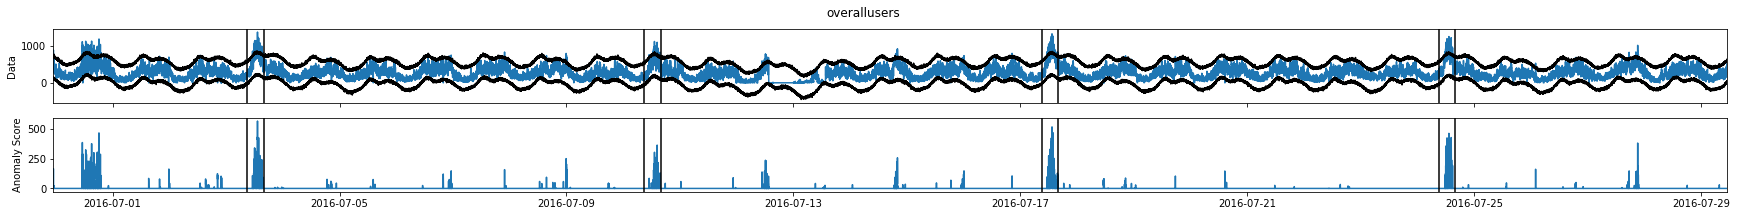

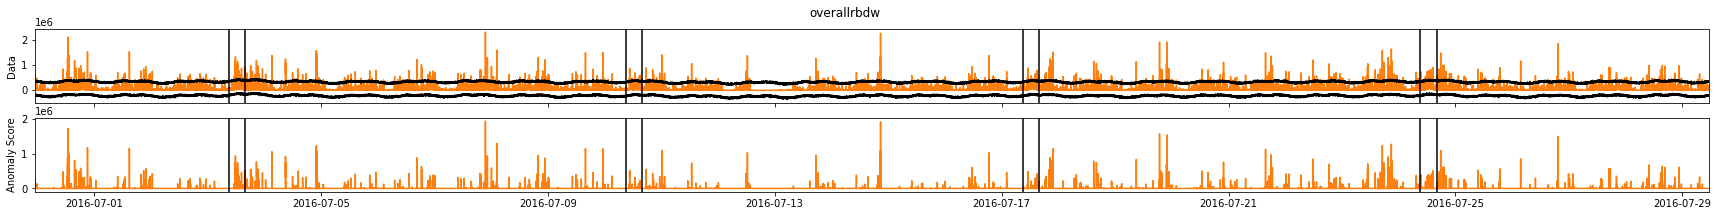

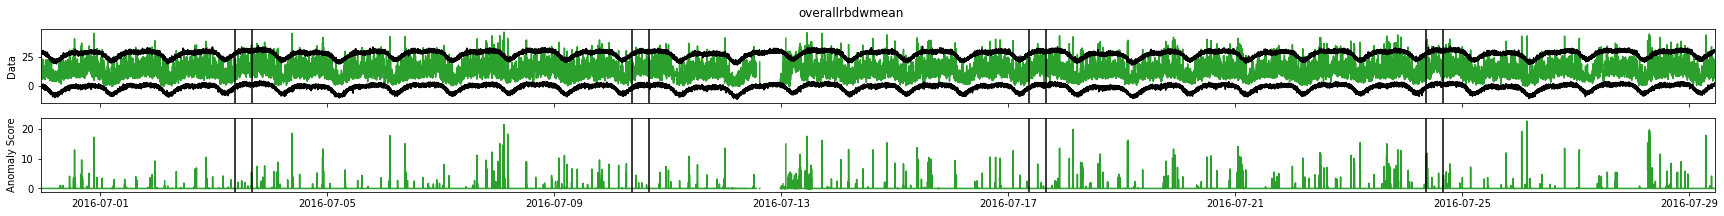

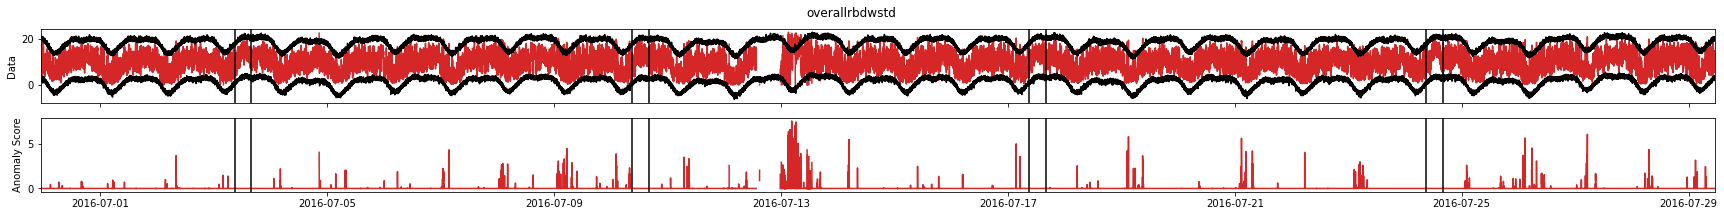

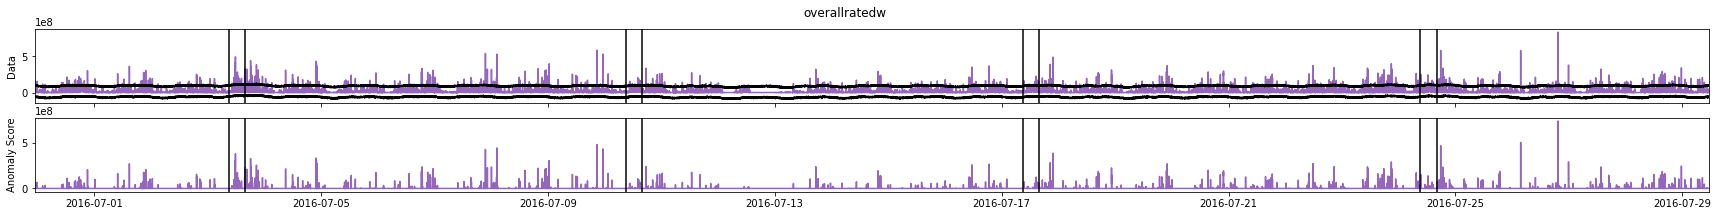

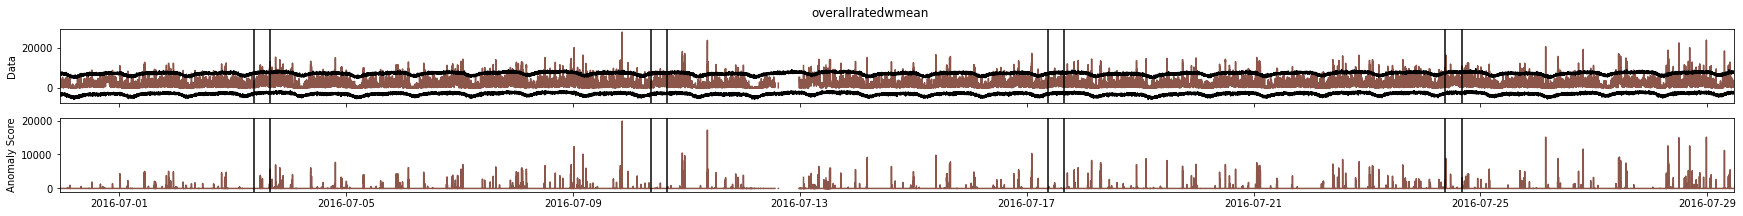

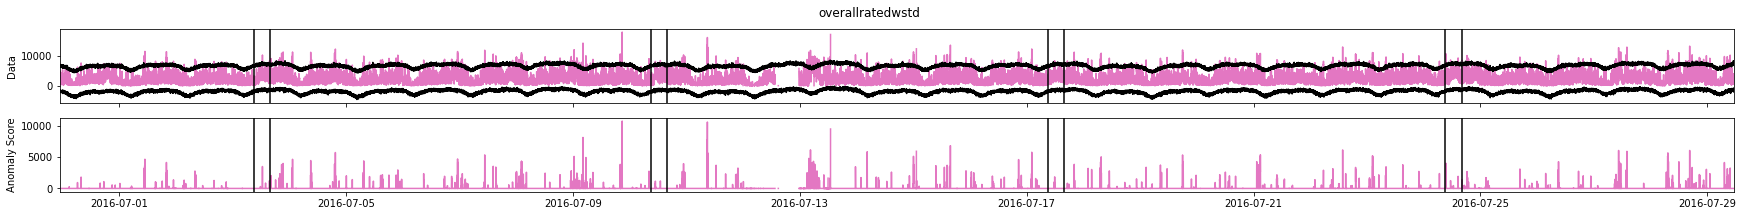

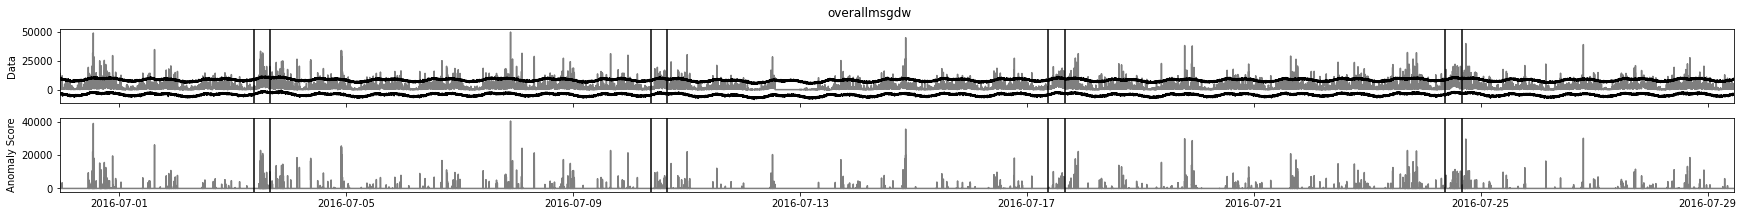

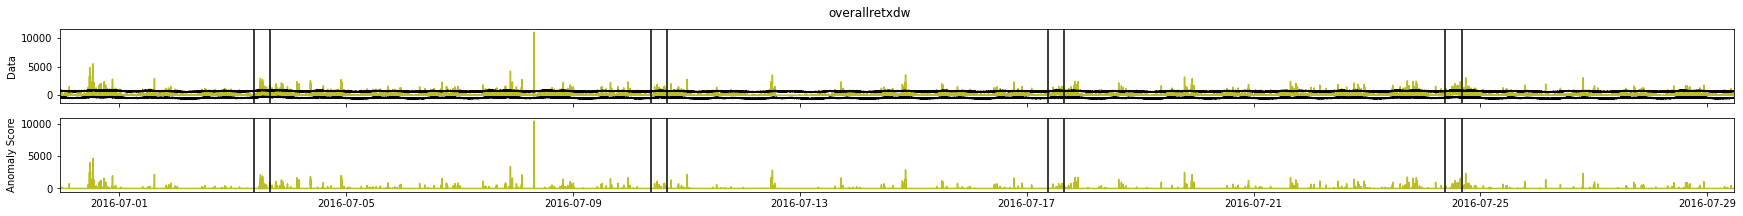

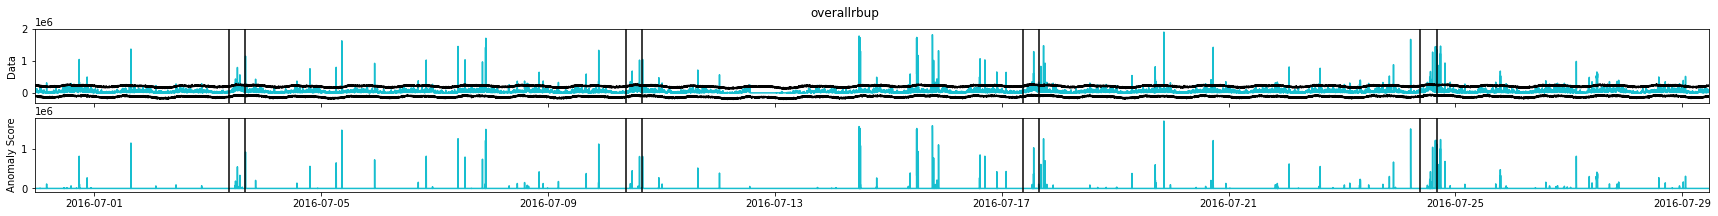

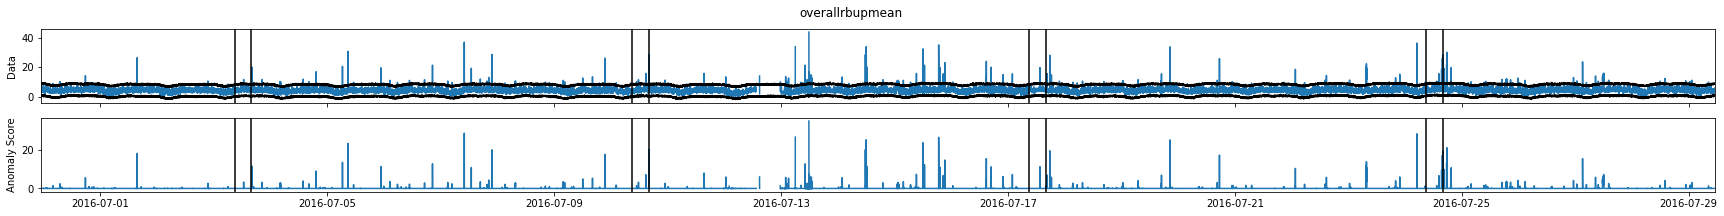

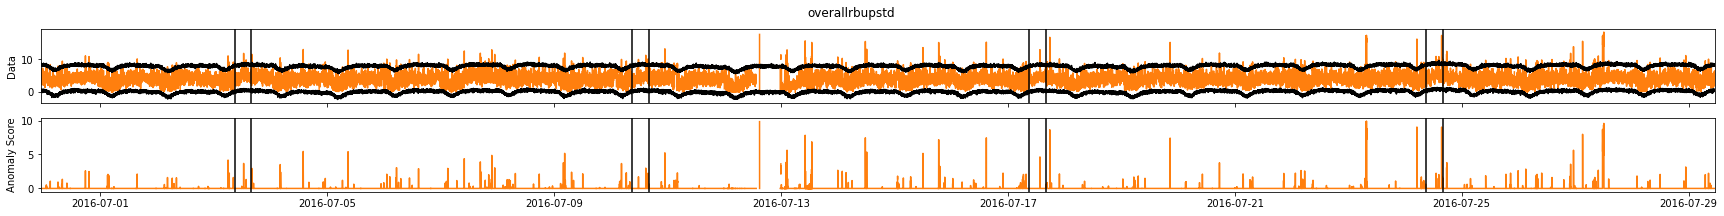

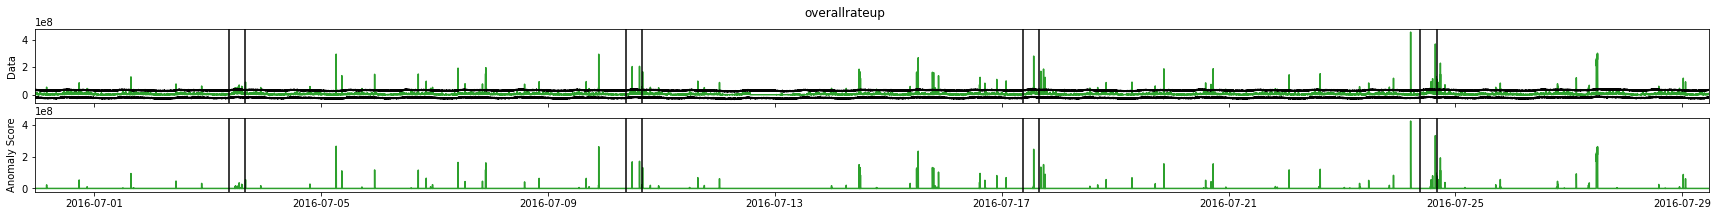

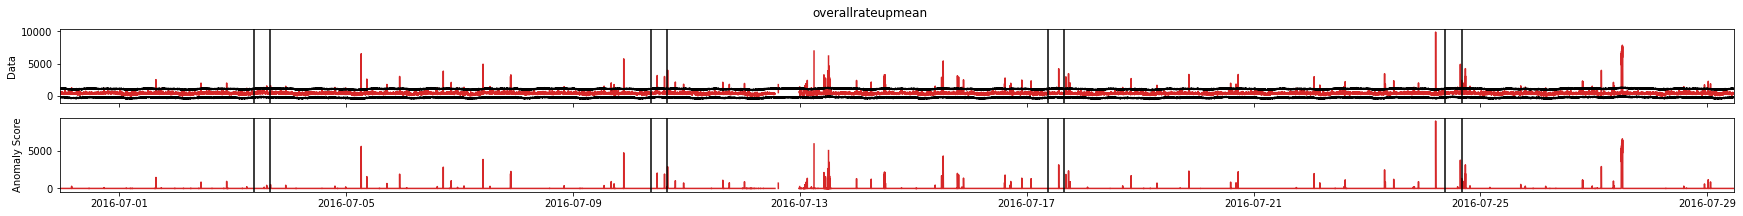

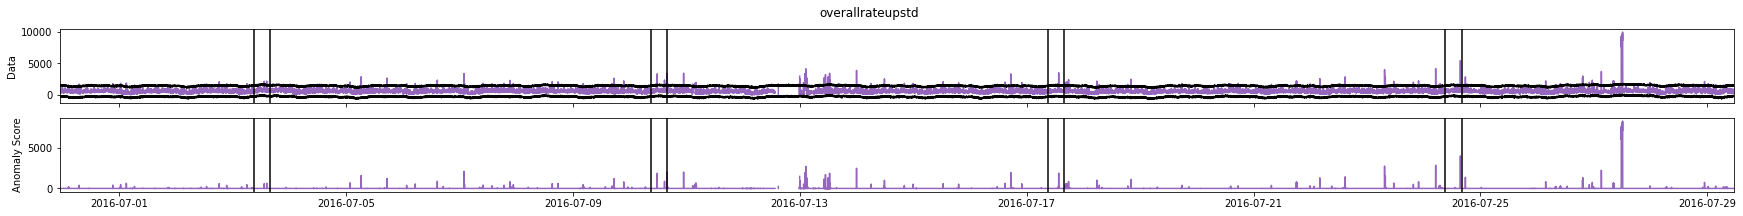

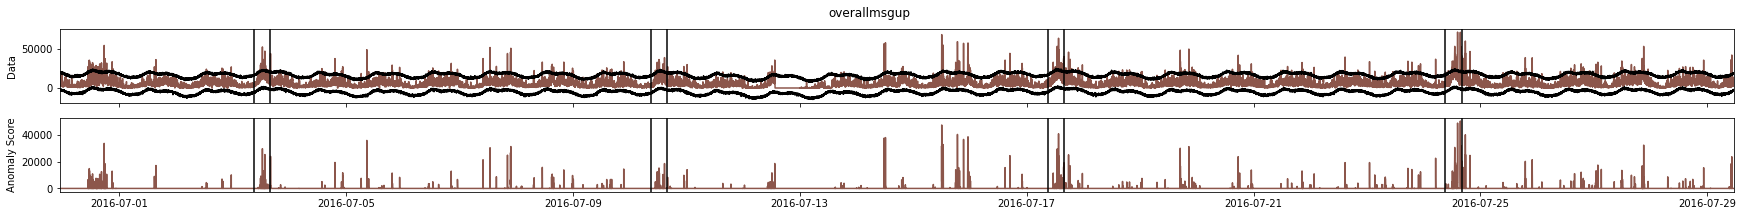

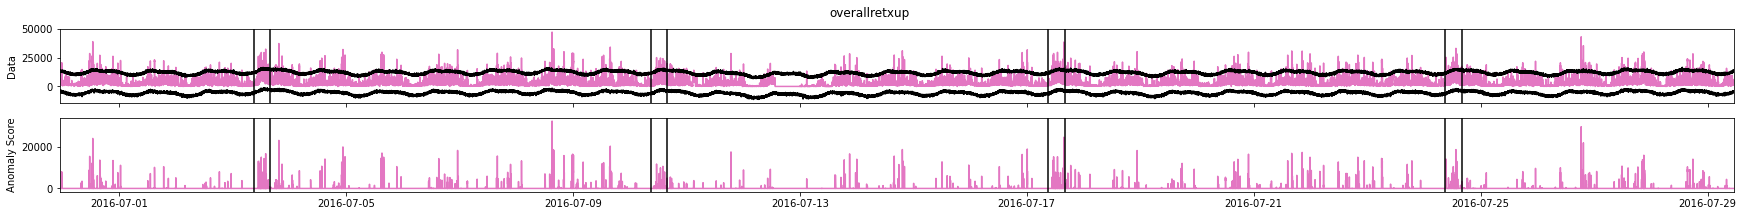

In [8]:
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

for (col,df),c in zip(res.items(), colors):
    _ = make_plot(df, col, c=c)
    plt.show()

In [11]:
dfs = []

for col, df in res.items():
    df = df[["anomaly"]].rename(columns={"anomaly":f"{col}_prophet"})
    dfs.append(df)

In [12]:
df_anomaly = pd.concat(dfs, axis=1)
df_anomaly.head()

,overallusers_prophet,overallrbdw_prophet,overallrbdwmean_prophet,overallrbdwstd_prophet,overallratedw_prophet,overallratedwmean_prophet,overallratedwstd_prophet,overallmsgdw_prophet,overallretxdw_prophet,overallrbup_prophet,overallrbupmean_prophet,overallrbupstd_prophet,overallrateup_prophet,overallrateupmean_prophet,overallrateupstd_prophet,overallmsgup_prophet,overallretxup_prophet
overalltime,,,,,,,,,,,,,,,,,
2016-06-29 22:56:00,0.00000,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-29 22:57:00,0.00000,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-29 22:58:00,167.09438,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-29 22:59:00,0.00000,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-29 23:00:00,0.00000,297197.456539,0.0,0.0,7.206527e+07,0.0,0.0,4530.167921,320.860851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_anomaly.to_csv("../anomaly/prophet.tar.gz", index=True)